In [1]:
#Import relevant libraries
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten

In [2]:
#Define the hyperparameters
BUFFER_SIZE = 70_000
BATCH_SIZE = 128
NUM_EPOCHS = 20

In [3]:
#Download the dataset
mnist_dataset, mnist_info = tfds.load(name='mnist', with_info = True, as_supervised=True)

mnist_train, mnist_test = mnist_dataset['train'],  mnist_dataset['test']


#Scaling the dataset. Fist cast the image to avoid value error
def scale(image,label):
    image = tf.cast(image, tf.float32)
    image /= 225.
    
    return image, label
    

In [4]:
train_and_validation_data = mnist_train.map(scale)
test_data = mnist_test.map(scale)

#creating the number of validation dataset from the training dataset
num_validation_samples = 0.1*mnist_info.splits['train'].num_examples

#convert number of the validation sample to an integer to prevent potential issue
num_validation_samples = tf.cast(num_validation_samples, tf.int64)

#get the number data point in our  test samples
num_test_samples = mnist_info.splits['test'].num_examples
num_test_samples = tf.cast(num_test_samples, tf.int64)

#Shuffle the training and validation dataset
shuffle_train_and_validation_data = train_and_validation_data.shuffle(BUFFER_SIZE)


#create the train data
train_data = shuffle_train_and_validation_data.skip(num_validation_samples)

#create the validation data
validation_data = shuffle_train_and_validation_data.take(num_validation_samples)


#batching the training data

train_data = train_data.batch(BATCH_SIZE)

#No need to batch the validation and test data(we are not backpropagating on them ). Hence we will take all at once]
validation_data = validation_data.batch(num_validation_samples)

test_data = test_data.batch(num_test_samples)

validation_inputs, validation_targets = next(iter(validation_data))




 

In [5]:
#Creating the model
model = Sequential([
        Conv2D(50, 5, activation= 'relu', input_shape=(28,28,1)),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(50, 3, activation= 'relu'),
        MaxPooling2D(pool_size=(2,2)),
        Flatten(),
        Dense(10)
])

In [6]:
model.summary(line_length=75)

Model: "sequential"
___________________________________________________________________________
 Layer (type)                    Output Shape                  Param #     
 conv2d (Conv2D)                 (None, 24, 24, 50)            1300        
                                                                           
 max_pooling2d (MaxPooling2D)    (None, 12, 12, 50)            0           
                                                                           
 conv2d_1 (Conv2D)               (None, 10, 10, 50)            22550       
                                                                           
 max_pooling2d_1 (MaxPooling2D)  (None, 5, 5, 50)              0           
                                                                           
 flatten (Flatten)               (None, 1250)                  0           
                                                                           
 dense (Dense)                   (None, 10)                    12510

In [7]:
#describe the loss function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#Compile the model

model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])


#Stop the model from overfitting ie whenever the validation loss increases
#the code tells the model to stop when the val_loss starts to increase in two subsequent epics

early_stopping = EarlyStopping(
    monitor= 'val_loss',
    mode = 'auto',
    min_delta = 0,
    patience = 2,
    verbose = 0,
    restore_best_weights = True
)

In [8]:
#Train the model
model.fit(
    train_data,
    epochs = NUM_EPOCHS,
    callbacks = [early_stopping],
    validation_data = validation_data,
    verbose =2
)

Epoch 1/20
422/422 - 35s - loss: 0.2663 - accuracy: 0.9225 - val_loss: 0.0729 - val_accuracy: 0.9773 - 35s/epoch - 82ms/step
Epoch 2/20
422/422 - 32s - loss: 0.0716 - accuracy: 0.9777 - val_loss: 0.0574 - val_accuracy: 0.9805 - 32s/epoch - 75ms/step
Epoch 3/20
422/422 - 31s - loss: 0.0526 - accuracy: 0.9837 - val_loss: 0.0441 - val_accuracy: 0.9862 - 31s/epoch - 74ms/step
Epoch 4/20
422/422 - 33s - loss: 0.0424 - accuracy: 0.9869 - val_loss: 0.0325 - val_accuracy: 0.9900 - 33s/epoch - 78ms/step
Epoch 5/20
422/422 - 33s - loss: 0.0365 - accuracy: 0.9887 - val_loss: 0.0322 - val_accuracy: 0.9912 - 33s/epoch - 79ms/step
Epoch 6/20
422/422 - 32s - loss: 0.0325 - accuracy: 0.9898 - val_loss: 0.0311 - val_accuracy: 0.9910 - 32s/epoch - 76ms/step
Epoch 7/20
422/422 - 32s - loss: 0.0265 - accuracy: 0.9916 - val_loss: 0.0186 - val_accuracy: 0.9942 - 32s/epoch - 76ms/step
Epoch 8/20
422/422 - 35s - loss: 0.0246 - accuracy: 0.9922 - val_loss: 0.0208 - val_accuracy: 0.9935 - 35s/epoch - 82ms/step


In [14]:
#Test the model
test_loss, test_accuracy = model.evaluate(test_data)

print(f'Test Loss: {round(test_loss,2)}. Test Accuracy:{round(test_accuracy*100,2)}%')

1/1 [==============================] - 1s 1s/step - loss: 0.0295 - accuracy: 0.9897
Test Loss: 0.03. Test Accuracy:98.97%


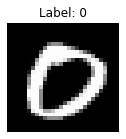

In [41]:

#Plot the image and result
import matplotlib.pyplot as plt
import numpy as np


# Get and display the first n images from the training dataset. n=2
num_images_to_display = 1
for image, label in test_data.take(num_images_to_display):
    sample_image = image.numpy()# Convert to numpy array and remove singleton dimensions
    sample_label = label.numpy()

original_images = sample_image.reshape(10000, 28, 28)

# Display the image using matplotlib
image_number_to_display = 6
plt.figure(figsize=(2,2))
plt.imshow(sample_image[image_number_to_display], cmap='gray', aspect="auto")
plt.title(f'Label: {sample_label[image_number_to_display]}')
plt.axis('off')  # Turn off axis
plt.show()

1/1 [==============================] - 0s 32ms/step


<BarContainer object of 10 artists>

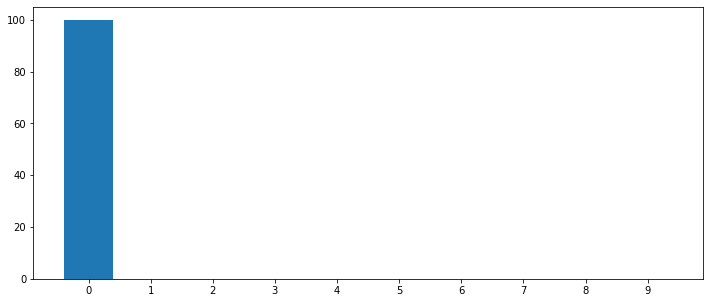

In [42]:
#Obtain the model's prediction(logits)

#Using slicing is important because tensorflow expects inputs to be in batches
predictions = model.predict(sample_image[image_number_to_display:image_number_to_display+1])

#Convert the predictions into probabilities and to percentage
probabilities = (tf.nn.softmax(predictions).numpy()) *100

#Create a bar chart to plot the probabilities for each class
plt.figure(figsize=(12,5))
plt.bar(x=[1,2,3,4,5,6,7,8,9,10], height=probabilities[0], tick_label=["0", "1","2","3","4","5","6","7","8","9"])